In [2]:
# General libraries
from os import path, listdir
from sys import path as sysPath

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For data preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For data analysis
from sklearn.metrics import confusion_matrix, accuracy_score

# For loading in Matt's python libraries for SPAM related content
sysPath.append( path.abspath( "../Support_Code/" ) )
import general_module as gm
import info_module as im
gm.test()
im.test()


GM: Hi!  You're in Matthew's module for generally useful functions and classes
IM: Hi!  You're in Matthew Ogden's information module for SPAM


In [3]:
tInfo = im.target_info_class( targetDir = '../../spam_data_pl3/587722984435351614/', printAll = False, newInfo=False)
print(tInfo.status)

True


In [4]:
# Read data 
wndDir = tInfo.targetDir + 'wndcharm/'
f1Loc = wndDir + 'f1_feats.csv'
f1DF = pd.read_csv(f1Loc,)
print(f1DF.shape)

X = f1DF.iloc[:,2:].values 
y = f1DF.iloc[:,1].values

yd1 = np.zeros(y.shape[0])
yd1[y>0.25] = 1
yd1 = yd1.astype(int)

(9972, 1752)


In [24]:
cList = list( f1DF.columns )
print(cList.pop(0))
print(cList.pop(0))

run_id
zoo_merger_score


(1750,)


In [30]:
# Retrieve top N items with highest classification association
from sklearn.feature_selection import mutual_info_classif
X_new = mutual_info_classif(X, yd1, n_neighbors=3, )

n = 10
topClassInd = X_new.argsort()[-n:][::-1]
topClass = X_new[topClassInd]

for i in range(n):
    print('%4d: %.3f   %s'%(topClassInd[i],topClass[i],cList[topClassInd[i]]))

  46: 0.217   Otsu Object Features () [29]
 160: 0.199   Comb Moments () [14]
   4: 0.197   Edge Features () [8]
   9: 0.191   Edge Features () [16]
1540: 0.185   Haralick Textures (Fourier (Edge ())) [8]
1535: 0.178   Haralick Textures (Fourier (Edge ())) [2]
1262: 0.178   Multiscale Histograms (Chebyshev (Wavelet ())) [10]
  78: 0.170   Chebyshev-Fourier Coefficients () [0]
1263: 0.170   Multiscale Histograms (Chebyshev (Wavelet ())) [11]
1362: 0.168   Comb Moments (Edge ()) [14]


In [22]:
from sklearn.feature_selection import mutual_info_regression
X_reg = mutual_info_regression(X, y, n_neighbors=3, )
print(X_reg.shape)

(1750,)


In [31]:
# Retrieve top N items with highest regression association
from sklearn.feature_selection import mutual_info_regression
X_reg = mutual_info_regression(X, y, n_neighbors=3, )

n = 10
topRegInd = X_reg.argsort()[-n:][::-1]
topReg = X_reg[topClassInd]

for i in range(n):
    print('%4d: %.3f   %s'%(topRegInd[i],topReg[i],cList[topRegInd[i]]))


   9: 0.593   Edge Features () [16]
   4: 0.594   Edge Features () [8]
   3: 1.836   Edge Features () [7]
   7: 1.869   Edge Features () [11]
 932: 0.351   Multiscale Histograms (Wavelet (Fourier ())) [8]
   8: 0.449   Edge Features () [12]
   6: 0.663   Edge Features () [10]
   2: 0.412   Edge Features () [6]
   5: 0.607   Edge Features () [9]
 753: 0.383   Multiscale Histograms (Chebyshev ()) [20]


In [49]:
top20Ind = np.unique( np.concatenate( (topClassInd, topRegInd) ) )

for ind in top20Ind:
    print(cList[ind])

X_select = X[:,top20Ind]


Edge Features () [6]
Edge Features () [7]
Edge Features () [8]
Edge Features () [9]
Edge Features () [10]
Edge Features () [11]
Edge Features () [12]
Edge Features () [16]
Otsu Object Features () [29]
Chebyshev-Fourier Coefficients () [0]
Comb Moments () [14]
Multiscale Histograms (Chebyshev ()) [20]
Multiscale Histograms (Wavelet (Fourier ())) [8]
Multiscale Histograms (Chebyshev (Wavelet ())) [10]
Multiscale Histograms (Chebyshev (Wavelet ())) [11]
Comb Moments (Edge ()) [14]
Haralick Textures (Fourier (Edge ())) [2]
Haralick Textures (Fourier (Edge ())) [8]


In [41]:
# Create black-box Artificial Nueral Network
import tensorflow as tf

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_select, y, test_size = 0.2, random_state = 0)

In [44]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=20, input_dim=X_select.shape[1], activation='relu'))
ann.add(tf.keras.layers.Dense(units=20, activation='relu'))
ann.add(tf.keras.layers.Dense(units=20, activation='relu'))
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
ann.compile( optimizer = 'adam', loss = 'mse', metrics = ['mean_absolute_error'] )
ann.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                380       
_________________________________________________________________
dense_5 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_6 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 21        
Total params: 1,241
Trainable params: 1,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = ann.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_split=0.2)

(1995,)
(1995, 1)
0.9194807518302653


Text(0.5, 1.0, 'WNDCHARM: Top 18 DNN\nCorrelation: 0.92')

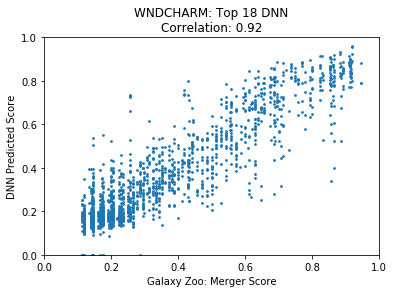

In [48]:
y_pred = ann.predict(X_test)
plt.scatter(y_test,y_pred,s=3)
plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel('Galaxy Zoo: Merger Score')
plt.ylabel('DNN Predicted Score')

title = 'Dense Neural Network'
print(y_test.shape)
print(y_pred.shape)
corr = np.corrcoef(y_test, y_pred[:,0])[0,1]
print(corr)

plt.title('WNDCHARM: Top 18 DNN\nCorrelation: %.2f'%corr)

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


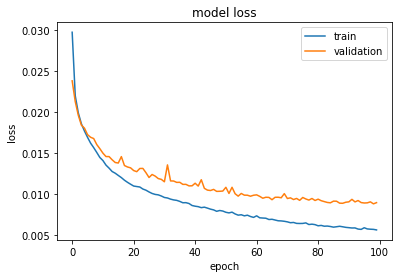

In [47]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()